In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Segmentation

--------------

## Separating an image into one or more regions of interest.

Everyone has heard or seen Photoshop or a similar graphics editor take a person from one image and place them into another.  The first step of doing this is *identifying where that person is in the source image*.

In popular culture, the Terminator's vision segments humans out of the overall scene:

<img src="./_static/terminator-vision.png" width="700px"/>

Segmentation is a fundamental operation in scientific image analysis because we often want to measure properties of real, physical *objects* such as cells embedded in our image. As such, we want to find those objects within our image.

Computationally, segmentations are most often represented as images, of the same size as the original image, containing integer *labels*, with one value representing one object.

Here is a very simple image and segmentation, taken from [this scikit-image gallery example](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py):

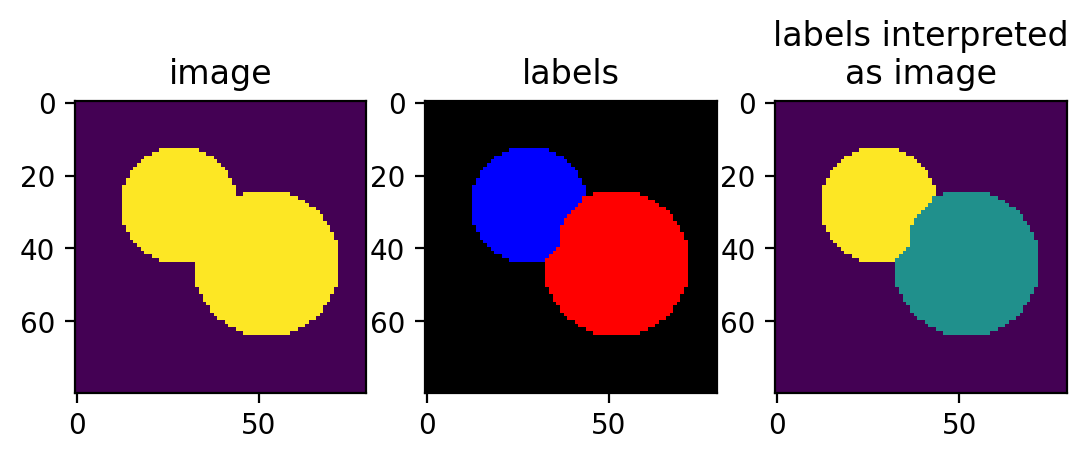

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

import napari

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.util import label_points
from skimage.color import label2rgb


# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
markers = label_points(coords, distance.shape)
labels = watershed(-distance, markers, mask=image)

# finally, plot the result
fig, ax = plt.subplots(1, 3)
ax[0].imshow(image)
ax[0].set_title('image')
ax[1].imshow(label2rgb(labels))
ax[1].set_title('labels')
ax[2].imshow(labels)
ax[2].set_title('labels interpreted\nas image');

Notice that "labels" is just a NumPy array with integer values. We have to be careful to interpret it as labels and not as an image.

## The napari viewer

To look at images and associated data, *napari* provides additional functionality over matplotlib, including:
- the canvas is OpenGL, interactive, and responsive
- the canvas has *layers*, which can be individually shown or hidden
- the viewer is *n-dimensional*, which comes in handy when your images are more than 2D, such as MRI data or (as below) microscopy data

Here's how to look at the same images with napari:

In [3]:
viewer = napari.Viewer()
image_layer = viewer.add_image(image)
labels_layer = viewer.add_labels(labels)
labels_as_image_layer = viewer.add_image(
    labels, name='labels as image'
)

### Exercise 0: play with the napari viewer

- zoom with scroll, pan with click and drag
- try clicking on the 👁️ icon on each layer in the layer list to make them invisible or visible again
- try changing the opacity, colormap, or interpolation on a layer
- try turning on "grid mode", from the group of buttons at the bottom-left of the viewer.
- *select* the labels layer, click on the paintbrush tool, and tweak the segmentation where the two labels meet.

## Segmenting nuclei and measuring cell properties

In the rest of this notebook, we will segment cell nuclei from a small sample image provided by the Allen Institute for Cell Science.

In [4]:
from skimage import data

cells3d = data.cells3d()

In [5]:
cells3d.shape  # zcyx

(60, 2, 256, 256)

In [6]:
cells3d.dtype

dtype('uint16')

In [7]:
np.max(cells3d)

65535

The pixel spacing in this dataset is 0.29µm in the z (leading!) axis, and 0.26µm in the x and y axes.

In [8]:
spacing = np.array([0.29, 0.26, 0.26])

We can view the 3D image using napari.

In [9]:
viewer, (membrane_layer, nuclei_layer) = napari.imshow(
    cells3d,
    channel_axis=1,  # remember, Python uses 0-based indexing!
    scale=spacing,
    name=['membranes', 'nuclei'],
    ndisplay=3,
)

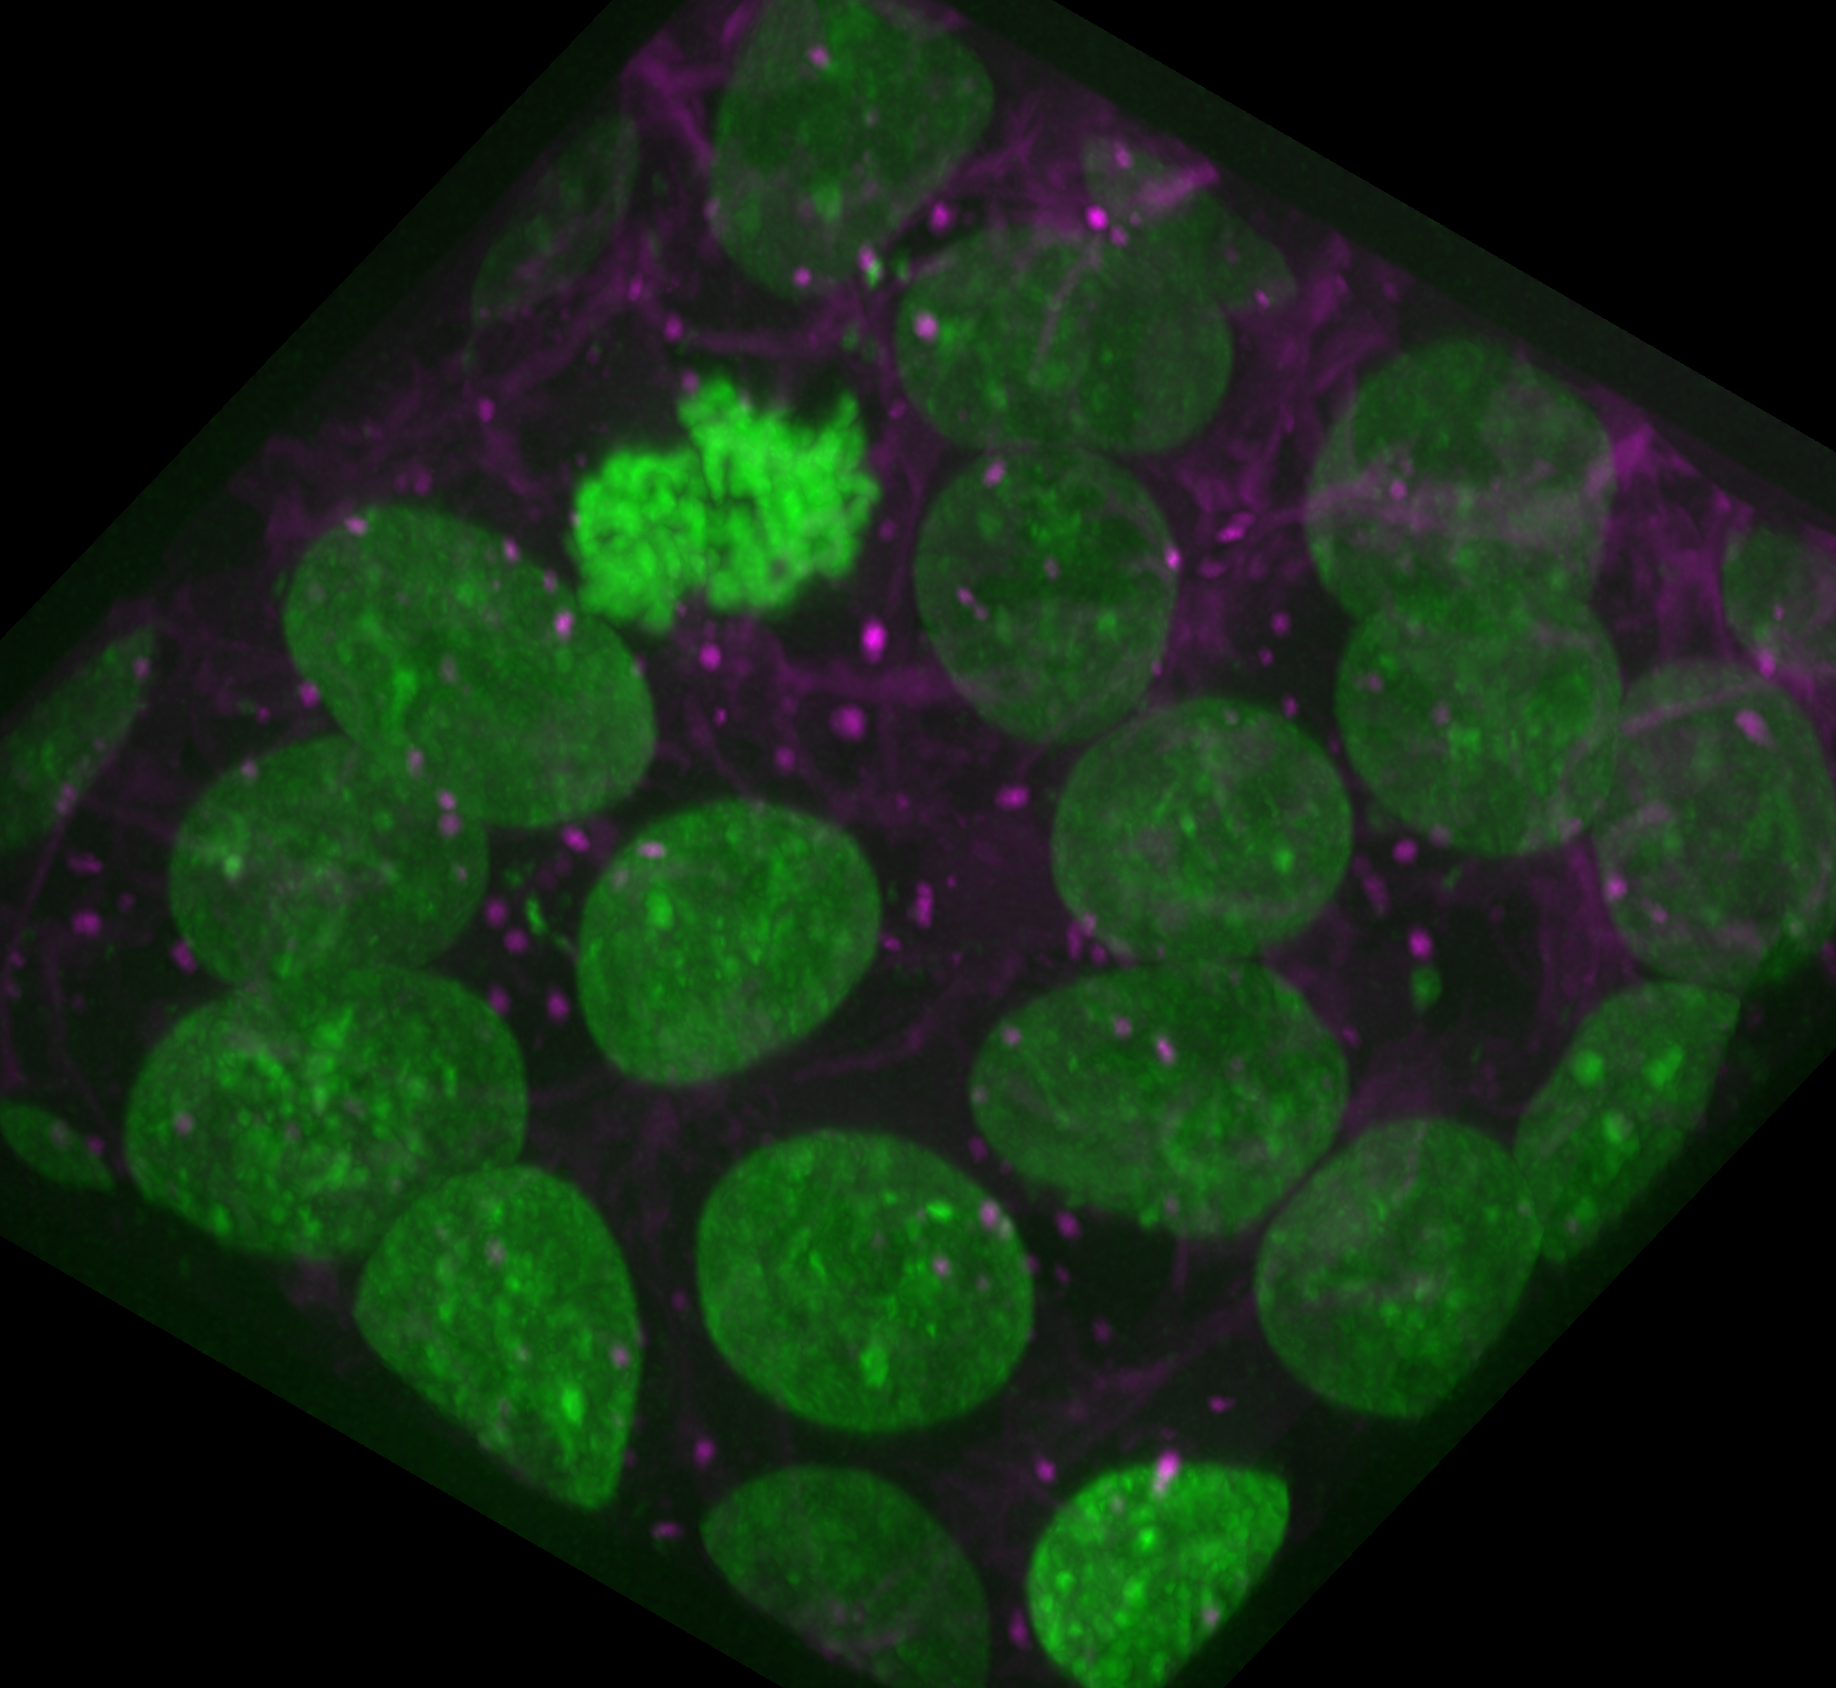

In [10]:
from napari.utils.notebook_display import nbscreenshot

viewer.dims.ndisplay = 3
viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

## Edge detection

We saw the [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) in the filters lesson. It is an edge detection algorithm that approximates the gradient of the image intensity, and is fast to compute. The [Scharr filter](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.scharr) is a slightly more sophisticated version, with smoothing weights [3, 10, 3]. Finally, the Farid & Simoncelli filter has [even more sophisticated weights](https://en.wikipedia.org/wiki/Image_derivative#Farid_and_Simoncelli_Derivatives). All three work for n-dimensional images in scikit-image.

In [11]:
# grab individual channels and convert to float in [0, 1]

membranes = cells3d[:, 0, :, :] / np.max(cells3d)
nuclei = cells3d[:, 1, :, :] / np.max(cells3d)

In [12]:
from skimage import filters


edges = filters.farid(nuclei)

edges_layer = viewer.add_image(
    edges,
    scale=spacing,
    blending='additive',
    colormap='yellow',
)

In [ ]:
nbscreenshot(viewer)

## Thresholding

[Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to create binary images. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker. In many cases, images can be adequately segmented by thresholding followed by labelling of *connected components*, which is a fancy way of saying "groups of pixels that touch each other".

Different thresholding algorithms produce different results. [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and [Li's minimum cross entropy threshold](https://scikit-image.org/docs/dev/auto_examples/developers/plot_threshold_li.html) are two common algorithms. Below, we use Li. You can use `skimage.filters.threshold_<TAB>` to find different thresholding methods.

In [ ]:
filters.threshold_

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


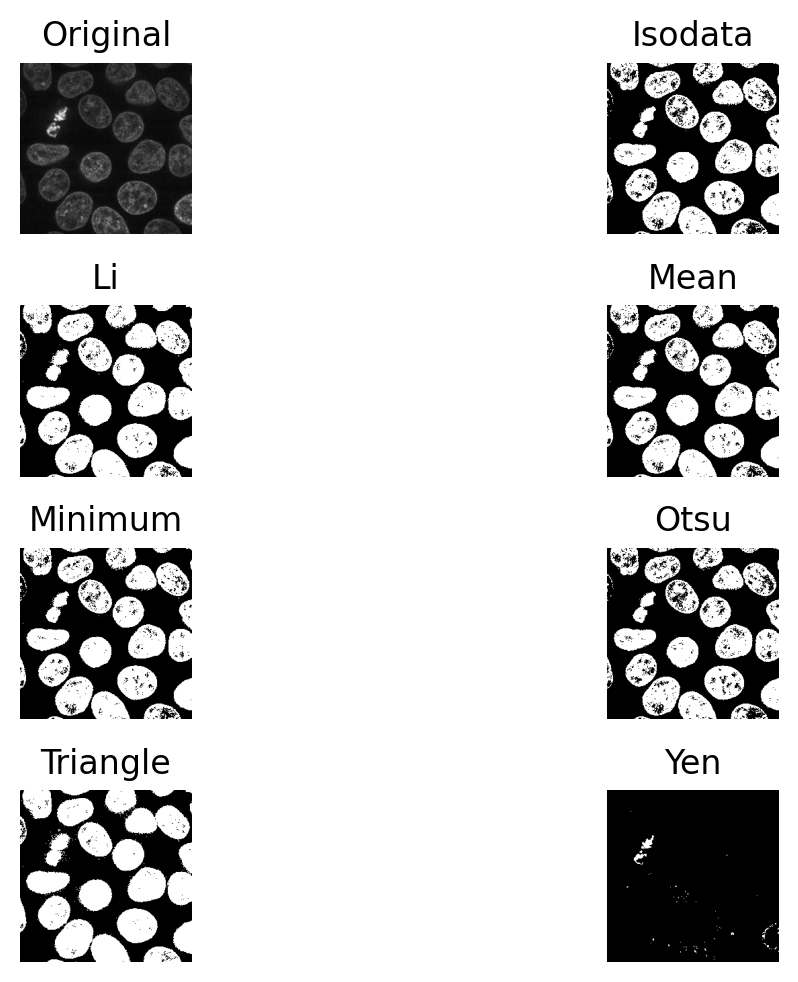

In [14]:
filters.try_all_threshold(nuclei[30]);

In [15]:
denoised = ndi.median_filter(nuclei, size=3)

In [21]:
filters.threshold_li(denoised)

0.13203153755917862

In [16]:
li_thresholded = denoised > filters.threshold_li(denoised)

In [17]:
threshold_layer = viewer.add_image(
    li_thresholded,
    scale=spacing,
    opacity=0.3,
)

In [ ]:
nbscreenshot(viewer)

We can see that the thresholded value is full of small holes, because of variation in pixel intensity inside the nuclei. Before proceeding further, we'd like to clean up those holes. Additionally, because of variations in the *background* intensity, some spurious small clumps of background pixels appear as foreground.

## Morphological operations

[Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) operations and structuring elements are defined in `skimage.morphology`. Structuring elements are shapes which define areas over which an operation is applied. The response to the filter indicates how well the neighborhood corresponds to the structuring element's shape.

There are a number of two and three dimensional structuring elements defined in `skimage.morphology`. Not all 2D structuring element have a 3D counterpart. The simplest and most commonly used structuring elements are the `disk`/`ball` and `square`/`cube`.

Functions operating on [connected components](https://en.wikipedia.org/wiki/Connected_space) can remove small undesired elements while preserving larger shapes.

`skimage.morphology.remove_small_holes` fills holes and `skimage.morphology.remove_small_objects` removes bright regions. Both functions accept a size parameter, which is the minimum size (in pixels) of accepted holes or objects. It's useful in 3D to think in linear dimensions, then cube them. In this case, we remove holes / objects of the same size as a cube 20 pixels across.

In [18]:
from skimage import morphology

In [19]:
width = 20

remove_holes = morphology.remove_small_holes(
    li_thresholded, width ** 3
)

In [20]:
width = 20

remove_objects = morphology.remove_small_objects(
    remove_holes, width ** 3
)

viewer.add_image(
    remove_objects,
    name='cleaned',
    scale=spacing,
    opacity=0.3,
);

viewer.layers['li_thresholded'].visible = False

In [ ]:
nbscreenshot(viewer)

## Segmentation

Now we are ready to label the connected components of this image.

In [22]:
from skimage import measure

labels = measure.label(remove_objects)

viewer.add_labels(
    labels,
    scale=spacing,
    opacity=0.5,
)

viewer.layers['cleaned'].visible = False

In [ ]:
nbscreenshot(viewer)

We can see that tightly packed cells connected in the binary image are assigned the same label.

A better segmentation would assign different labels to different nuclei. 

Typically we use [watershed segmentation](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) for this purpose. We place *markers* at the center of each object, and these labels are expanded until they meet an edge or an adjacent marker.

The trick, then, is how to find these markers.

A common approach, which we saw above with the two overlapping circles, is to compute the distance transform of a binary mask, and place markers at the local maxima of that transform.

As you will see below, it can be quite challenging to find markers with the right location. A slight amount of noise in the image can result in very wrong point locations.

In [23]:
signal = np.random.random(100)

In [24]:
smoothed = filters.gaussian(signal, sigma=5)

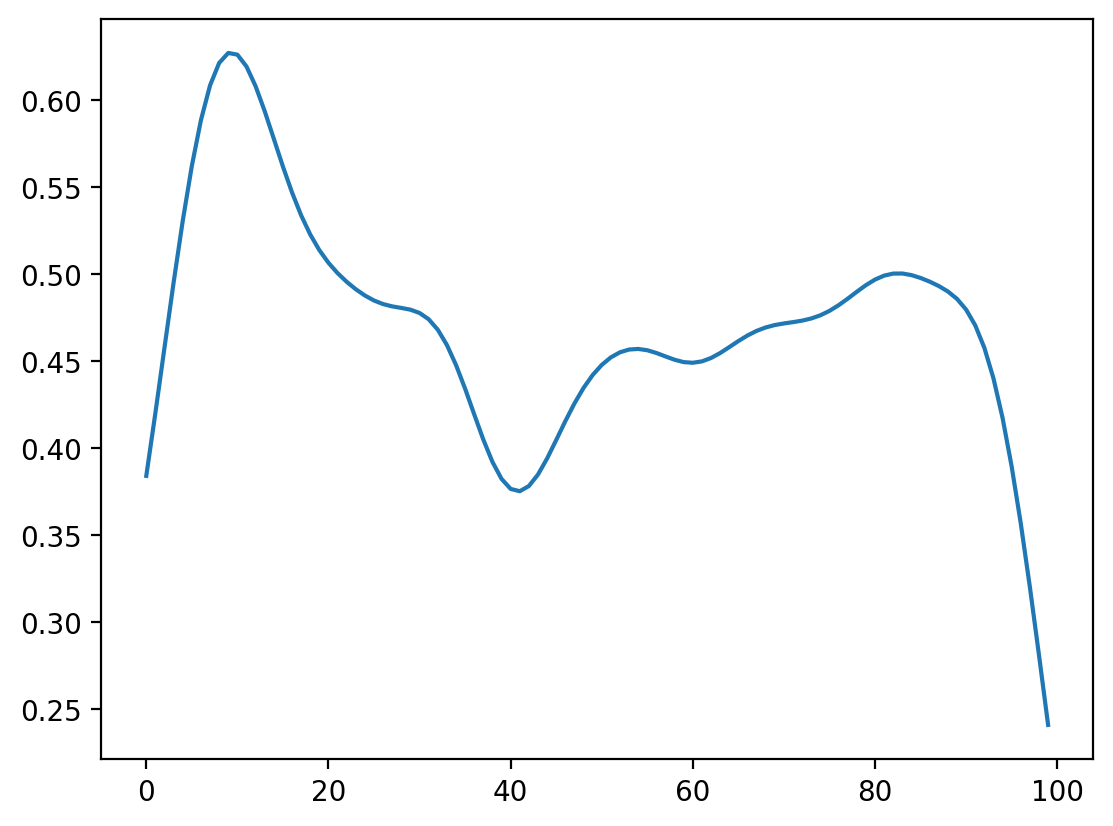

In [25]:
plt.plot(smoothed)

In [26]:
markers = np.zeros(smoothed.shape, dtype=int)

In [27]:
markers[[0, 41, 60, 99]] = [1, 2, 3, 4]

In [28]:
segmented_signal = watershed(smoothed, markers)

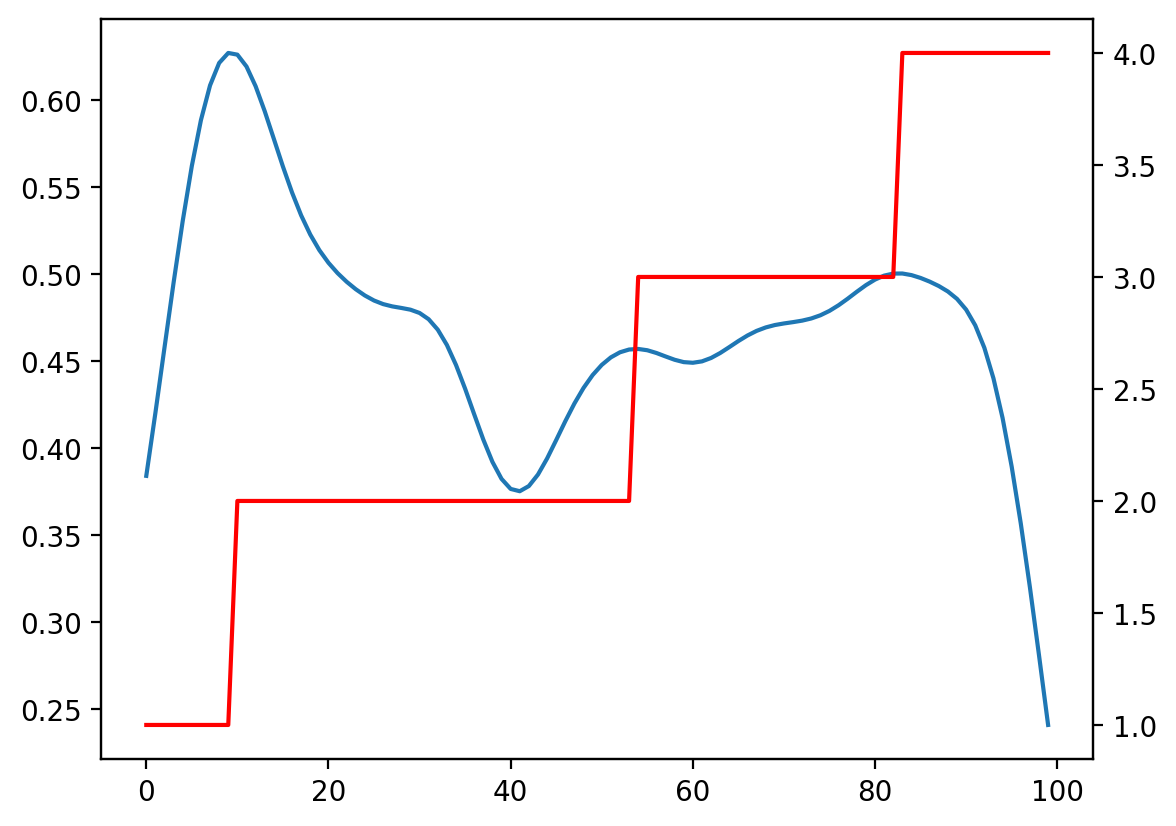

In [31]:
fig, ax = plt.subplots()

ax.plot(smoothed)
ax1 = ax.twinx()
ax1.plot(segmented_signal, c='r')

In [32]:
transformed = ndi.distance_transform_edt(
    remove_objects, sampling=spacing
)

In [33]:
viewer.add_image(transformed,
                 scale=spacing,
                 name='dt',
                 colormap='magma',
                )

<Image layer 'dt' at 0x2dc042230>

In [34]:
maxima = morphology.local_maxima(transformed)
viewer.add_points(
    np.transpose(np.nonzero(maxima)),
    name='bad points',
    scale=spacing,
    size=4,
    n_dimensional=True,  # points have 3D "extent"
)

<Points layer 'bad points' at 0x2b67b58d0>

In [ ]:
nbscreenshot(viewer)

You can see that these points are actually terrible, with many markers found within each nuclei.

### Exercise 1: improve the points

Try to improve the segmentation to assign one point for each nucleus. Some ideas:

- use a smoothed version of the nuclei image directly
- smooth the distance map
- use morphological operations to smooth the surface of the nuclei to ensure that they are close to spherical
- use peak_local_max with `min_distance` parameter instead of `morphology.local_maxima`
- find points on a single plane, then prepend the plane index to the found coordinates

In [39]:
better_points = peak_local_max(transformed, min_distance=20)
better_points_layer = viewer.add_points(
    better_points,
    name='better points?',
    scale=spacing,
    n_dimensional=True,
    size=4,
)

In [41]:
smooth_nuclei = filters.gaussian(
    nuclei,
    sigma=10,
)

points = peak_local_max(smooth_nuclei, min_distance=5)
gauss_points_layer = viewer.add_points(
    points,
    name='gauss points',
    scale=spacing,
    n_dimensional=True,
    size=4,
)

### Mixing manual annotation and algorithms

As you will have seen from the previous exercise, there are many approaches to find better seed points, but they are often fiddly and tedious, and sensitive to parameters — when you encounter a new image, you might have to start all over again!

With napari, in many cases, a little interactivity, combined with the segmentation algorithms in scikit-image and elsewhere, can quickly get us the segmentation we want.

Below, you can use full manual annotation, or light editing of the points you found automatically.

In [ ]:
viewer.layers['bad points'].visible = False
viewer.dims.ndisplay = 2
viewer.dims.set_point(0, 30 * spacing[0])

points = viewer.add_points(
    name='interactive points',
    scale=spacing,
    ndim=3,
    size=4,
    n_dimensional=True,
)
points.mode = 'add'


# now, we annotate the centers of the nuclei in your image

In [ ]:
viewer.dims.ndisplay = 3
viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer)

In [ ]:
# unscaled points.data
# this cell is only to simulate interactive annotation,
# no need to run it if you already have annotations.
# If for some reason you don't, you can uncomment the code below


# points.data = np.array(
#       [[ 30.        ,  14.2598685 ,  27.7741219 ],
#        [ 30.        ,  30.10416663,  81.36513029],
#        [ 30.        ,  13.32785096, 144.27631406],
#        [ 30.        ,  46.8804823 , 191.80920846],
#        [ 30.        ,  43.15241215, 211.84758551],
#        [ 30.        ,  94.87938547, 160.12061219],
#        [ 30.        ,  72.97697335, 112.58771779],
#        [ 30.        , 138.21820096, 189.01315585],
#        [ 30.        , 144.74232372, 242.60416424],
#        [ 30.        ,  98.14144685, 251.92433962],
#        [ 30.        , 153.59649032, 112.58771779],
#        [ 30.        , 134.49013081,  40.35635865],
#        [ 30.        , 182.95504275,  48.74451649],
#        [ 30.        , 216.04166532,  80.89912152],
#        [ 30.        , 235.14802483, 130.296051  ],
#        [ 30.        , 196.00328827, 169.44078757],
#        [ 30.        , 245.86622651, 202.06140137],
#        [ 30.        , 213.71162148, 250.52631331],
#        [ 28.        ,  87.42324517,  52.00657787]],
#       dtype=float,
# )

Once you have marked all the points, you can grab the data back, and make a markers image for `skimage.segmentation.watershed`:

In [42]:
from skimage import segmentation, util

marker_locations = gauss_points_layer.data


markers = util.label_points(marker_locations, nuclei.shape)
markers_big = morphology.dilation(markers, morphology.ball(5))

segmented = segmentation.watershed(
    edges,
    markers_big,
    mask=remove_objects,
)

final_segmentation = viewer.add_labels(
    segmented,
    scale=spacing,
    blending='translucent_no_depth',  # don't hide enclosed points
)

viewer.layers['labels'].visible = False

In [ ]:
nbscreenshot(viewer)

After watershed, we have better disambiguation between internal cells!

## Making measurements

Once we have defined our objects, we can make measurements on them using `skimage.measure.regionprops` and `skimage.measure.regionprops_table`. These measurements include features such as area or volume, bounding boxes, and intensity statistics.

Before measuring objects, it helps to clear objects from the image border. Measurements should only be collected for objects entirely contained in the image.

Given the layer-like structure of our data, we only want to clear the objects touching the sides of the volume, but not the top and bottom, so we pad and crop the volume along the 0th axis to avoid clearing the mitotic nucleus.

In [ ]:
segmented_padded = np.pad(
    segmented,
    ((1, 1), (0, 0), (0, 0)),
    mode='constant',
    constant_values=0,
)

In [ ]:
interior_labels = segmentation.clear_border(segmented_padded)[1:-1]

`skimage.measure.regionprops` automatically measures many labeled image features. Optionally, an `intensity_image` can be supplied and intensity features are extracted per object. It's good practice to make measurements on the original image.

Not all properties are supported for 3D data. Below we build a list of supported and unsupported 3D measurements.

In [43]:
regionprops = measure.regionprops(segmented, intensity_image=nuclei)

supported = [] 
unsupported = []

for prop in regionprops[0]:
    try:
        regionprops[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("3D/nD properties:")
print("  " + "\n  ".join(supported))
print()
print("2D-only properties:")
print("  " + "\n  ".join(unsupported))

3D/nD properties:
  area
  area_bbox
  area_convex
  area_filled
  axis_major_length
  axis_minor_length
  bbox
  centroid
  centroid_local
  centroid_weighted
  centroid_weighted_local
  coords
  equivalent_diameter_area
  euler_number
  extent
  feret_diameter_max
  image
  image_convex
  image_filled
  image_intensity
  inertia_tensor
  inertia_tensor_eigvals
  intensity_max
  intensity_mean
  intensity_min
  label
  moments
  moments_central
  moments_normalized
  moments_weighted
  moments_weighted_central
  moments_weighted_normalized
  slice
  solidity

2D-only properties:
  eccentricity
  moments_hu
  moments_weighted_hu
  orientation
  perimeter
  perimeter_crofton


scikit-image 0.18 adds support for [passing custom functions](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) for region properties as `extra_properties`. After this tutorial, you might want to try it out to [determine the surface area](https://github.com/scikit-image/scikit-image/issues/3797#issuecomment-471277056) of the nuclei or cells!

`skimage.measure.regionprops` ignores the 0 label, which represents the background.

`regionprops_table` returns a dictionary of columns compatible with creating a pandas dataframe of properties of the data:

In [45]:
import pandas as pd


info_table = pd.DataFrame(
    measure.regionprops_table(
        segmented,
        intensity_image=nuclei,
        properties=['label', 'slice', 'area', 'mean_intensity', 'solidity'],
    )
).set_index('label')

In [46]:
info_table.head()

slice     area  \
label                                                               
1      (slice(14, 60, None), slice(58, 93, None), sli...  19692.0   
3      (slice(17, 53, None), slice(133, 184, None), s...  42514.0   
4      (slice(17, 53, None), slice(192, 252, None), s...  58059.0   
5      (slice(17, 58, None), slice(120, 159, None), s...  48231.0   
6      (slice(19, 50, None), slice(176, 228, None), s...  48979.0   

       mean_intensity  solidity  
label                            
1            0.342820  0.684463  
3            0.247120  0.925727  
4            0.213399  0.905418  
5            0.232108  0.890380  
6            0.231506  0.901310

We can now use pandas and seaborn for some analysis!

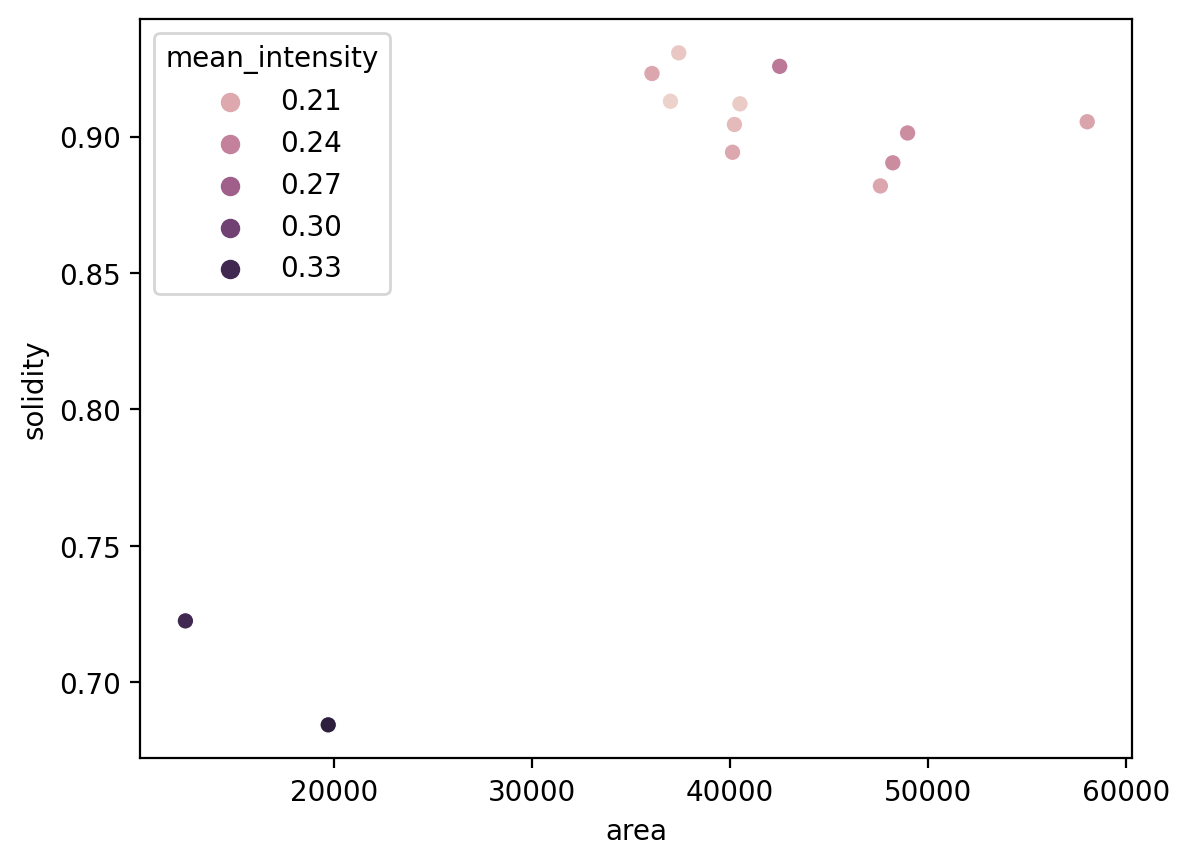

In [47]:
import seaborn as sns

sns.scatterplot(x='area', y='solidity', data=info_table, hue='mean_intensity');

We can see that the mitotic nucleus is a clear outlier from the others in terms of solidity and intensity.

### Exercise 2: physical measurements

The "area" property above is actually the volume of the region, measured in voxels. Add a new column to your dataframe, `'area_um3'`, containing the volume in µm&sup3;. *Hint: remember the voxel spacing we noted at the start of the tutorial. You only need pandas to do this.*

In [48]:
spacing

array([0.29, 0.26, 0.26])

In [50]:
um3_per_vox = np.prod(spacing)  # µm3

In [51]:
info_table['area (µm3)'] = info_table['area'] * um3_per_vox

In [52]:
info_table.head()

slice     area  \
label                                                               
1      (slice(14, 60, None), slice(58, 93, None), sli...  19692.0   
3      (slice(17, 53, None), slice(133, 184, None), s...  42514.0   
4      (slice(17, 53, None), slice(192, 252, None), s...  58059.0   
5      (slice(17, 58, None), slice(120, 159, None), s...  48231.0   
6      (slice(19, 50, None), slice(176, 228, None), s...  48979.0   

       mean_intensity  solidity   area (µm3)  
label                                         
1            0.342820  0.684463   386.041968  
3            0.247120  0.925727   833.444456  
4            0.213399  0.905418  1138.188636  
5            0.232108  0.890380   945.520524  
6            0.231506  0.901310   960.184316

### Exercise 3: displaying regionprops (or other values)

Now that you have segmented cells, (or even with just the nuclei), use [`skimage.util.map_array`](https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.map_array) to display a volume of the value of a regionprop (say, 'solidity' of the cells) on top of the segments.

In [ ]:
# Solution here